In [1]:
from scipy.io import loadmat
import numpy as np
import jax
from jax import numpy as jnp

import sys
sys.path.append('..')
from src.dynamics import *
from src.environment import *
from src.containers import *
from utils.test_utils import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = loadmat("IRTmesh.mat")

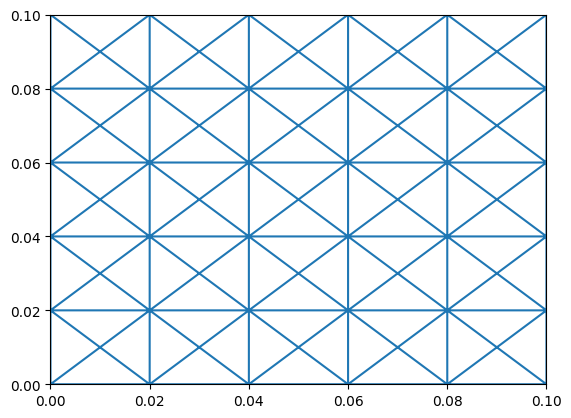

In [3]:
xy = np.asarray([data["NODE"][0,i][2,0][:,0] for i in range(data["NODE"].size)])
x = xy[:,0]
y = xy[:,1]
tri = np.asarray([data["CELL"][0,i][6:9][:,0] for i in range(data["CELL"].size)])-1
plt.triplot(x,y,tri)
plt.axis([0,.1,0,.1])
plt.show()

In [4]:
# Given physical parameters
Re = 100            # Reynolds number
nu_phys = 0.001     # physical kinematic viscosity
L = 2.0             # domain length (physical units)
dx = 0.02           # spatial step (physical units)
dt = 0.1            # time step (physical units)

# Speed of sound squared for D2Q9 lattice
c_s_sq = 1.0 / 3.0

# Compute physical lid velocity
U_phys = Re * nu_phys / L

# Convert to lattice units
U_lattice = U_phys * dt / dx
nu_lattice = nu_phys * dt / (dx ** 2)

# Compute relaxation time tau
Tau = nu_lattice / c_s_sq + 0.5

# Print results
print(f"Lid velocity (physical units): {U_phys:.5f}")
print(f"Lid velocity (lattice units): {U_lattice:.5f}")
print(f"Viscosity (lattice units): {nu_lattice:.5f}")
print(f"Relaxation time tau: {Tau:.5f}")
U_lid = U_lattice

Lid velocity (physical units): 0.05000
Lid velocity (lattice units): 0.25000
Viscosity (lattice units): 0.25000
Relaxation time tau: 1.25000


In [5]:
Environment.dynamics = D2Q9(tau=Tau,delta_t = dt)

env = Environment.create(data["CELL"].size,data["FACE"].size,data["NODE"].size)

In [6]:
cell_order = np.array([cell[0] for cell in data["CELL"][0,:]],dtype=np.int32)-1
cell_faces = np.array([cell[15:18] for cell in data["CELL"][0,:]],dtype=np.int32)[...,0]-1
def get_normal_dir(cell_index):
    cell_faces = np.asarray([data["CELL"][0,cell_index][i][0][0] for i in range(15,18)],dtype=np.int32)-1
    cell_normals = np.asarray([data["CELL"][0,cell_index][i][0][0] for i in range(33,36)],dtype=np.float32)
    face_normals = np.asarray([data["FACE"][0,i][3][0][0] for i in cell_faces.flatten()],dtype=np.float32)
    signs = np.sign([np.dot(cell_normals[i], face_normals[i]) for i in range(3)])
    return signs
cell_normals = np.array([get_normal_dir(i) for i in range(len(cell_order))])

/var/folders/2n/7nnz5dsd7j51q45dv749mhth0000gn/T/ipykernel_91092/3802725191.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cell_order = np.array([cell[0] for cell in data["CELL"][0,:]],dtype=np.int32)-1
/var/folders/2n/7nnz5dsd7j51q45dv749mhth0000gn/T/ipykernel_91092/3802725191.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cell_faces = np.array([cell[15:18] for cell in data["CELL"][0,:]],dtype=np.int32)[...,0]-1


In [7]:
env.cells.face_indices = jnp.asarray(cell_faces,jnp.int32)
env.cells.face_normals = jnp.asarray(cell_normals,dtype=jnp.int32)

In [8]:
def dist(x,y):
    return np.sqrt(np.sum((x-y)**2,axis=-1))

In [9]:
L = np.array([data["FACE"][0,face_index][2][0][0] for face_index in range(data["FACE"].size)])
n = np.array([data["FACE"][0,face_index][3][0][0] for face_index in range(data["FACE"].size)])
nodes = np.array([data["FACE"][0,face_index][7:9][:,0] for face_index in range(data["FACE"].size)],dtype=np.int32)-1
cells = np.array([np.stack([data["FACE"][0,face_index][11][0][0,0],data["FACE"][0,face_index][12][0][0,0]]) for face_index in range(data["FACE"].size)],dtype=np.int32)-1
face_loc = np.array([data["FACE"][0,face_index][6][0][:,0] for face_index in range(data["FACE"].size)])
cell_dists = np.array([[dist(data["CELL"][0,cell][4][0][:,0],face_loc[face_index]) for cell in cells[face_index]] for face_index in range(data["FACE"].size)])
cell_dists = np.where(cells == -1,cell_dists[59978,0],cell_dists)

/var/folders/2n/7nnz5dsd7j51q45dv749mhth0000gn/T/ipykernel_91092/540708938.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nodes = np.array([data["FACE"][0,face_index][7:9][:,0] for face_index in range(data["FACE"].size)],dtype=np.int32)-1


In [10]:
env.faces.L = jnp.asarray(L,dtype=jnp.float32)
env.faces.n = jnp.asarray(n,dtype=jnp.float32)
env.faces.nodes_index = jnp.asarray(nodes,dtype=jnp.int32)
env.faces.stencil_cells_index = jnp.asarray(cells,dtype=jnp.int32)
env.faces.stencil_dists = jnp.asarray(cell_dists,dtype=jnp.float32)

In [11]:
for node in data["NODE"][0,:]:
    node_index = jnp.asarray(node[0][0][0][0],dtype=jnp.int32)-1
    print(node_index)
    cells_index = jnp.asarray(node[4][0][0],dtype = jnp.int32)-1
    cells_dist = jnp.asarray(node[5][0][:,0],dtype = jnp.float32)
    env.nodes.cells_index.add_items(node_index,cells_index) 
    env.nodes.cell_dists.add_items(node_index,cells_dist)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [14]:
type = np.array([data["NODE"][0,i][1][0][0] for i in range(data["NODE"].size)],dtype=np.int32)
env.nodes.type = jnp.asarray(type,dtype=jnp.int32)
for i in range(data["NODE"].size):
    if type[i]==1:
        cords = data["NODE"][0,i][2][0][:,0]
        if cords[1] == 0:
            env.nodes.vel = env.nodes.vel.at[i].set(jnp.array([U_lid,0],dtype=jnp.float32))

In [14]:
import pickle

env.init()
def save_env(env, filename):
    with open(filename, 'wb') as f:
        pickle.dump(env, f)

In [15]:
save_env(env, 'env.pkl')

In [12]:
import pickle
def load_env(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
env = load_env('env.pkl')
env.dynamics = D2Q9(tau=Tau,delta_t = dt)

In [61]:
for i in tqdm(range(1000000)):
    env = env.step()

  6%|▋         | 62683/1000000 [03:32<53:03, 294.47it/s]  


KeyboardInterrupt: 

In [19]:
env = env.step()

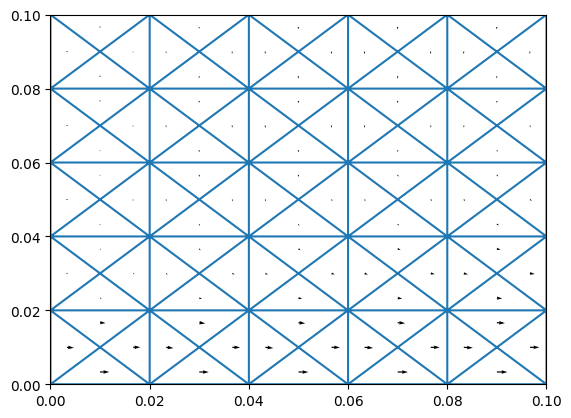

In [62]:
xy = np.array([data["CELL"][0,i][4][0][:,0] for i in range(data["CELL"].size)])
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel 
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.quiver(x,y,vel[:,0],vel[:,1],scale=10)
plt.axis([0,.1,0,.1])
xy = np.asarray([data["NODE"][0,i][2,0][:,0] for i in range(data["NODE"].size)])
x = xy[:,0]
y = xy[:,1]
tri = np.asarray([data["CELL"][0,i][6:9][:,0] for i in range(data["CELL"].size)])-1
plt.triplot(x,y,tri)
plt.axis([0,.1,0,.1])
plt.show()

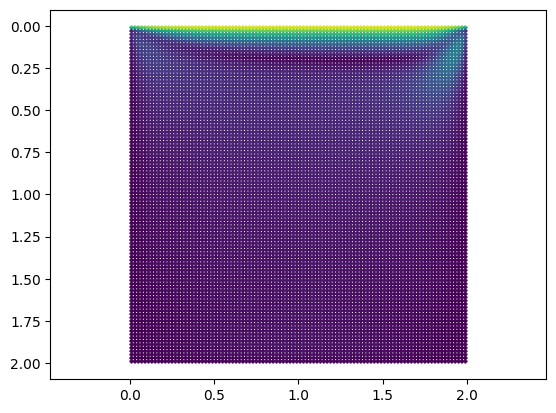

In [67]:
xy = np.array([data["CELL"][0,i][4][0][:,0] for i in range(data["CELL"].size)])
x = xy[:,0]
y = xy[:,1]
vel = env.cells.vel
mag = np.sqrt(np.sum(vel**2,axis=-1))
plt.scatter(x,y,c=mag,cmap='viridis',vmin=0,vmax=U_lid,s=.5)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

In [108]:
from scipy.interpolate import NearestNDInterpolator
interp = NearestNDInterpolator(xy, vel)

ValueError: different number of values and points

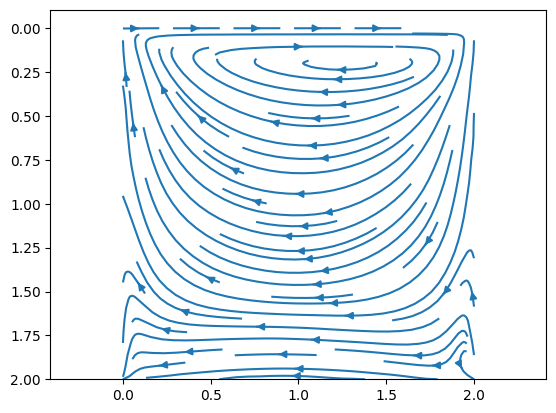

In [109]:
x = np.linspace(0, 2, 1000)
y = np.linspace(0, 2, 1000)
x,y = np.meshgrid(x, y)
vel = interp(x,y)
plt.streamplot(x, y, vel[:,:,0], vel[:,:,1],density=1)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

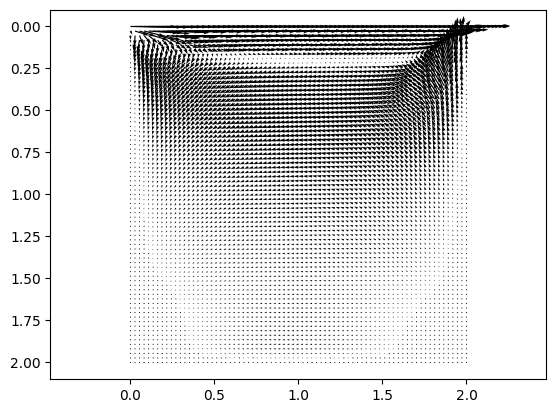

In [125]:
x = np.linspace(0, 2, 75)
y = np.linspace(0, 2, 75)
x,y = np.meshgrid(x, y)
vel = interp(x,y)
plt.quiver(x,y,vel[:,:,0],vel[:,:,1],scale=2)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

In [114]:
from scipy.io import loadmat
data = loadmat('../ref/ldc_Re100.mat')
refu = data['u'].T[...,jnp.newaxis]
refv = data['v'].T[...,jnp.newaxis]
refx = data['x'].squeeze()
refy = data['y'].squeeze()
# x,y = jnp.meshgrid(x,y)
# x = jnp.expand_dims(x.flatten(),axis=-1)
# y = jnp.expand_dims(y.flatten(),axis=-1)
# xy = jnp.concatenate((x,y),axis=-1)
sol = jnp.concatenate((refu,refv),axis=-1)
solx = sol[128,:,1]
soly = sol[:,128,0]

In [143]:
x = np.linspace(0, 2, 1000)
y = np.linspace(0, 2, 1000)
outx = interp(x,np.ones_like(x))[...,1]/U_lid
outy = interp(np.ones_like(y),y)[...,0]/U_lid

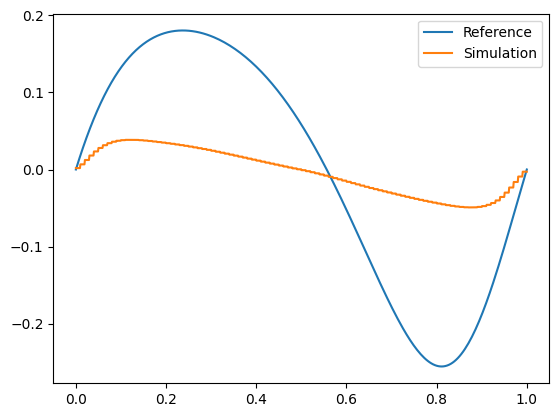

In [146]:
plt.plot(refy,solx)
plt.plot(x/2,-outx)
plt.legend(['Reference','Simulation'])
plt.show()

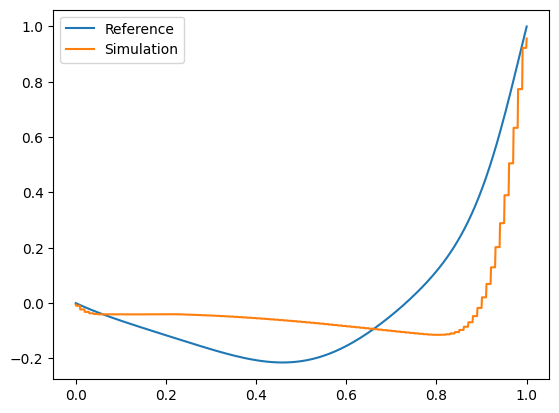

In [145]:
plt.plot(refy,soly)
plt.plot(np.flip(y)/2,outy)
plt.legend(['Reference','Simulation'])
plt.show()